<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/Cjnsultant_Professional/improvement_5_1_Prototyp_revisor_face_recognition_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подтягивание базы с Github,

подсчет токенов для каждого фрагмента и построение графика,

суммаризация диалога,

отображение стоимости вопрос-ответа и

суммы за весь диалог.

для выхода из режима диалога с консультантом наберите  в окне диалоговом - stop

In [2]:
!pip install -q langchain_openai==0.0.2 faiss-cpu==1.7.4 openai==1.6.1 tiktoken==0.5.2 langchain_community==0.0.11 langchain==0.1.0

In [3]:
!pip install PyGithub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 12.8 MB/s eta 0:00:00


In [4]:
from openai import OpenAI
import os
from google.colab import userdata
import re
import requests
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document

In [5]:
# Получение API ключа из пользовательских данных Colab и установка его как переменной среды
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

Добавил расчет стоимости диалога >>>

In [6]:
# Стоимость за 1 токен
TOKEN_COST = 0.000000225  # Примерная стоимость одного токена в USD, можно скорректировать

def calculate_cost(token_count: int) -> float:
    """
    Функция для расчета стоимости на основе количества токенов.
    """
    return token_count * TOKEN_COST


In [7]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

Блок отвечающий за подтягивание базы знаний с Github

1) нужно на место многоточия вставить свой токен Github

2) Загрузка данных из GitHub: Функция load_document_from_github загружает текстовый файл из GitHub, используя токен доступа.

Проверка данных: Проверяется, удалось ли загрузить данные, и выводятся первые 1000 символов для проверки.

Обработка текста: Текст разбивается на чанки с помощью MarkdownHeaderTextSplitter.

Подсчет токенов: Функция num_tokens_from_string подсчитывает количество токенов в каждом чанке.

Построение графика: Строится гистограмма распределения длин чанков в токенах.

# ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

  Преподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ
  
  Город: Чита
  
  ПРАКТИЧЕСКИЙ КУРС
  28 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  МАСТЕР-КЛАСС
  29 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  Место проведения: Будет объявлено дополнительно
  Стоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.
  
  Дополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.
  
  ПРОГРАММА :
  Научитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике
  
  Почти на вс

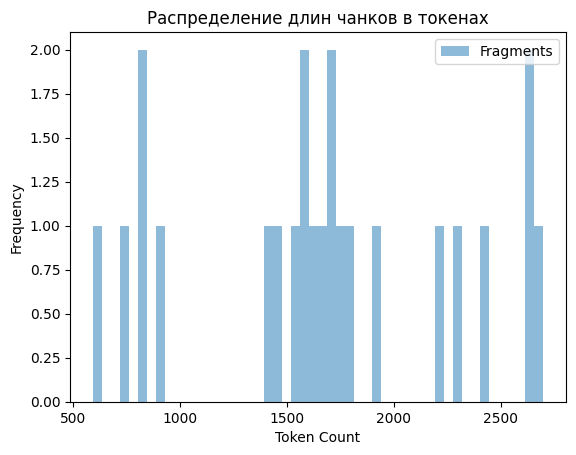

In [8]:
from github import Github
import re
import tiktoken
import matplotlib.pyplot as plt
from langchain.text_splitter import MarkdownHeaderTextSplitter

# Загрузка документа с GitHub
def load_document_from_github(url: str, github_token: str) -> str:
    match = re.match(r"https://github.com/([^/]+)/([^/]+)/blob/([^/]+)/(.*)", url)
    if not match:
        raise ValueError("Invalid GitHub URL")
    username, repo_name, branch, file_path = match.groups()

    g = Github(github_token)
    repo = g.get_repo(f"{username}/{repo_name}")
    file_content = repo.get_contents(file_path, ref=branch)
    return file_content.decoded_content.decode('utf-8')

# Загрузка базы знаний из GitHub
github_url = 'https://github.com/NeuronsUII/GPT_Professional/blob/main/Baza_znaniy/baza.txt'
github_token = '.......'  # Замените на ваш токен с Github

try:
    data_from_github = load_document_from_github(github_url, github_token)
    print(data_from_github[:1000])  # Вывод первых 1000 символов документа для проверки
except Exception as e:
    print(f"Error loading document: {e}")

# Убедимся, что текст был загружен
if 'data_from_github' in locals():
    # Разделение текста на чанки
    splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "Header 1")])
    fragments = splitter.split_text(data_from_github)

    # Функция для подсчета токенов
    def num_tokens_from_string(text: str, model_name: str) -> int:
        encoding = tiktoken.get_encoding(model_name)
        tokens = encoding.encode(text)
        return len(tokens)

    # Проверка, что каждый фрагмент является строкой
    fragments = [fragment if isinstance(fragment, str) else str(fragment) for fragment in fragments]

    fragment_token_counts = [num_tokens_from_string(fragment, "cl100k_base") for fragment in fragments]

    # Построение графика распределения длин токенов
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Распределение длин чанков в токенах')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
else:
    print("Ошибка: данные не были загружены из GitHub.")


бдлок загрузки базы знаний с Github закончен

In [9]:
# Вывод первых 1000 символов документа для проверки
print(data_from_github[:1000])

# ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

  Преподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ
  
  Город: Чита
  
  ПРАКТИЧЕСКИЙ КУРС
  28 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  МАСТЕР-КЛАСС
  29 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  Место проведения: Будет объявлено дополнительно
  Стоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.
  
  Дополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.
  
  ПРОГРАММА :
  Научитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике
  
  Почти на вс

In [10]:
# Указание заголовков, по которым будет происходить разделение
headers_to_split_on = [
    ("#", "Header 1"),
]

# Создание объекта MarkdownHeaderTextSplitter для разделения текста
splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Разделение текста на чанки
chunks = splitter.split_text(data_from_github)

# Вывод чанков
for i, chunk in enumerate(chunks):
    print(f"Чанк {i+1}:\n{chunk}\n")

Чанк 1:
page_content='ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024  \nПреподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ  \nГород: Чита  \nПРАКТИЧЕСКИЙ КУРС\n28 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМАСТЕР-КЛАСС\n29 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМесто проведения: Будет объявлено дополнительно\nСтоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.  \nДополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.  \nПРОГРАММА :\nНаучитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике  \nПочти на всех курсах в качестве практики выполняют реставрацию резца в макс

In [11]:
# Инструкция в system

system = load_document_text('https://docs.google.com/document/d/1jOpPZ5Boz1774QOjOANGuoK-cUPN7ohPWdnsIioGxz8/edit?usp=sharing') # заполняем параметр ссылкой на составленный промпт. Не забываем открыть доступ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Вывод первых 4000 символов system
print(system[:4000])

﻿Ты известный практикующий врач стоматолог , преподаватель и консультант учебного центра ООО «ПРОФЕССИОНАЛ», курсы повышения квалификации и непрерывного образования для врачей стоматологов в различных городах России. Все наши мероприятия проходят аккредитацию по линии НМО с получением кредитов. 


Предоставь точную информацию о курсах повышения квалификации и непрерывного образования для врачей-стоматологов, доступных в различных городах России. 
При ответах на вопросы используй базу знаний с информацией о курсах,  данную тебе. Ничего от себя не придумывай и отвечай строго по тексту базы знаний про каждый конкретный курс. У каждого курса есть своя программа, свой лектор и варианты городов и дат проведения обучения, не путай их между собой. Особенно аккуратно обращайся с датами проведения курсов, ты должен предоставить очень точную информацию по датам. Ответы на вопросы клиентов должны быть точными и релевантными, строго исходя из базы знаний. 


Если клиент спрашивает подробную програм

In [13]:
# выводим несколько чанков, чтобы убедиться, что все получилось в необходимом нам формате
chunks[0:5]

[Document(page_content='ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024  \nПреподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ  \nГород: Чита  \nПРАКТИЧЕСКИЙ КУРС\n28 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМАСТЕР-КЛАСС\n29 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМесто проведения: Будет объявлено дополнительно\nСтоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.  \nДополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.  \nПРОГРАММА :\nНаучитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике  \nПочти на всех курсах в качестве практики выполняют реставрацию резца в ма

In [14]:
len(chunks)

23

In [15]:
# Инициализируем модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(chunks, embeddings)

Отдельный блок для сохранения базы Faiss (если необходимо)

In [16]:
# Задаем имя и путь для сохранения файла
folder_path = '/content/drive/MyDrive/'
index_name = "db"

In [17]:
# Сохраняем db на ваш Google Drive
db.save_local(folder_path=folder_path, index_name=index_name)

In [18]:
# Путь к сохраненному файлу
saved_file_path = f"{folder_path}{index_name}"

In [19]:
# Настройка общего доступа и получение ссылки вручную
print(f"Файл сохранен в {saved_file_path}. Перейдите на Google Drive, найдите файл и настройте общий доступ.")

Файл сохранен в /content/drive/MyDrive/db. Перейдите на Google Drive, найдите файл и настройте общий доступ.


In [ ]:
# Вывод ссылки для ручного копирования и настройки общего доступа
drive_link = f"https://drive.google.com/drive/u/0/my-drive"
print(f"Ссылка на ваш Google Drive: {drive_link}")

Ссылка на ваш Google Drive: https://drive.google.com/drive/u/0/my-drive


Конец блока сохранения базы Faiss

In [20]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [21]:
# Функция для ответа на вопросы с использованием индекса. Модифицирована и возвращает еще и стоимость ответа.
def answer_index(system, topic, search_index, verbose=0):
    """
    Функция для ответа на вопросы с использованием индекса и расчета стоимости.

    Args:
      system:
      topic:
      search_index:
      verbose:

    Returns:
      answer: Ответ на вопрос
      cost: Стоимость ответа в USD
    """
    # Поиск релевантных отрезков из базы знаний
    docs = search_index.similarity_search(topic, k=4)
    if verbose: print('\n ===========================================: ')

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)

    client = OpenAI()
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    if verbose: print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",  # Выберите модель
        messages=messages,
        temperature=0  # Указываем значение
    )

    answer = completion.choices[0].message.content

    # Подсчет токенов
    token_count = num_tokens_from_string(message_content + answer, "cl100k_base")
    cost = calculate_cost(token_count)

    return answer, cost


In [22]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

In [23]:
# Модифицирована и теперь она будет включать расчет стоимости для каждого вопроса и ответа
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя с расчетом стоимости.
    """
    summarized_history = ""
    if len(question_history) > 0:
        # Извлекаем только вопросы и ответы для саммаризации
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " + \
                              summarize_questions([q + ' ' + (a if a else '') for q, a, *_ in question_history])
                              # Используем *_ для распаковки дополнительных элементов (стоимость) и игнорирования их

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ и стоимость
    answer, cost = answer_index(system, topic, db)

    question_history.append((user_question, answer if answer else '', cost))

    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    print(f"Стоимость текущего вопроса и ответа: ${cost:.4f}")

    return answer, cost



In [24]:
def run_dialog(system_doc_url, knowledge_base_url):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    question_history = []
    total_cost = 0.0

    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer, cost = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history)
        total_cost += cost
        print('Консультант:', insert_newlines(answer))

    print(f"Общая стоимость диалога: ${total_cost:.2f}")
    return



In [25]:
# Провеяем работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах.
# После запуска, вводите ваши вопросы в консоли. Для завершения сеанса диалога, введите stop.
run_dialog(system, db)

Пользователь: Здравствуйте. Я Дмитрий . Интересует курс возраст резца
Стоимость текущего вопроса и ответа: $0.0015
Консультант:  Здравствуйте, Дмитрий! Курс "Возраст резца" пройдет 28-29 сентября 2024 года в Чите. **Преподаватель:** Сошников Алексей Сергеевич. **Место проведения:** Будет объявлено
 дополнительно. **Стоимость:** - Семинар: 16 500 рублей. - Семинар + мастер-класс: 42 000 рублей (при внесении аванса 10 000 рублей до 28 августа, стоимость составит 40
 000 рублей). Дополнительно можно получить Свидетельство НМО на 36 баллов за 3 000 рублей. **Программа курса включает:** - Научитесь видеть и воспроизводить зубы разных
 возрастных групп композитом в прямой технике. - Практика реставрации резца в максимальной анатомии для различных возрастных групп. - Обсуждение частых проблем и вопросов
 при реставрации. **Ссылка на программу курса:** [Программа курса "Возраст
 резца"](https://profistomat.ru/wp-content/uploads/2024/04/Programma-Soshnikov-VOZRAST-REZTSA-28-29-sentyabrya-CHIta.